## Setup

Since this is a handin exercise I will shortly outline the setup required for this notebook to run (assuming I can only hand in the `.ipynb` file). The notebook pulls from the dependencies in the first code block. To install all relevant libraries run (assuming you have `jupyter` installed):

```shell
python -m pip install pandas tensorflow sklearn
```

Additionally it required the data and labels to be available as follows:
1. the batch data is located in a `data` folder next to the notebook
2. the label information is stored as `labels.csv` next to the notebook

In [46]:
import os
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Load Data

First the data needs to be loaded (first codeblock) and then go through some minor transformations before building the training, test and validation datasets. For this purpose all data is loaded into a flat dataframe that includes the batch and corresponding label in addition to the actual features `zeit`, `sensorid` und `messwert`. In preparation for the model training the `zeit` is transformed to float values and the data types of `sensorid` and `label` are adjusted.

In [47]:
# parse the labels.csv
labels = pd.read_csv('labels.csv', index_col=0)
labels = labels.sort_values('id')

# grab filenames from the data directory
filenames = os.listdir('data')
filenames.sort()

dataframes = []

# parse and concatenate all csv files into df
for filename in filenames:
  if filename.endswith('.csv'):
    batch = pd.read_csv(os.path.join('data',filename), index_col=0)
    batch['batch'] = int(filename.replace('.csv', ''))
    dataframes.append(batch)

df = pd.concat(dataframes, ignore_index=True)

# clean up original dataframes
del dataframes

# add label column (if it is not already available)
if (not 'label' in df.columns):
  df = df.merge(labels, left_on=["batch"], right_on=["id"])


In [48]:
def time_to_float(inputstr):
  hours, minutes, seconds = map(float, inputstr.split(':'))

  # return hours * 3600 + minutes * 60 + seconds
  # this is sufficient because hours should always be 0
  return minutes * 60 + seconds

if (not df['sensorid'].dtype == 'int'):
  df['sensorid'] = df['sensorid'].astype('int')
if (not df['label'].dtype == 'category'):
  df['label'] = df['label'].astype('category')
if (not df['zeit'].dtype == 'float64'):
  df['zeit'] = df['zeit'].apply(time_to_float)

# print(df[:10])
# print(labels[:10])


### Prepare Training Data

This step was only introduced once I decided to use a recurrent neural network (specifically an LSTM). The flat dataframe created before has to be broken down into small sequences that will be fed to the model. As to not created sequences with mixed labels, the data was grouped by `batch`. Additionally it is important that each batch is sorted by `zeit` since order of readings in sequences is relevant. After splitting each batch into equally sized sequences (dropping any additional readings at the end that were not able to make a full sequence), the data is split into training, test and validation data sets.

In [49]:
SEQUENCE_LENGTH = 256

sequences = []
sequence_labels = []

# build sequences based on chosen sequence length
for batch, readings in df.groupby('batch'):
  readings = readings.sort_values('zeit')
  for i in range(0, len(readings) - SEQUENCE_LENGTH, SEQUENCE_LENGTH):
    sequence = readings.iloc[i:i + SEQUENCE_LENGTH]
    sequences.append(sequence[['zeit', 'sensorid', 'messwert']].values)
    sequence_labels.append(sequence['label'].values[0])

# transform to numpy arrays for tensorflow
sequences = np.array(sequences)
sequence_labels = np.array(sequence_labels)

# split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, sequence_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


### Modelling & Training

The initial plan was to train a simple NN, that is fed `zeit`, `sensorid` and `messwert` as features to predict the label, but it became apparent quickly, that this approach would not lead to the reuqired accurracy. After some additional research, I settled on an LSTM which is able to detect and learn patterns in the sequences. Batch size and the number of LSTM units was determined using a grid search and running it over night to determine the best `SEQUENCE_LENGTH`, `LSTM_UNITS` and `BATCH_SIZE`. The grid search revealed, that among the chosen options the largest options for `SEQUENCE_LENGTH` and `LSTM_UNITS` performed the best with an accuracy of about 76%.

The model itself is implemented as Sequential Model using Tensorflow keras. It consists of 2 layers:

- the aforementioned LSTM layer, handling the input and pattern detection
- a densely connected layer using softmax activations to produce the predictions

The model was then trained using the adam optimiser and set up for early training termination, based on the validation loss each round to prevent overfitting. Each 8 epochs the model weights were saved, as a safety measure should model training crash at any point.

In [50]:
# make key hyperparameters accessible and easy to tune
BATCH_SIZE = 64
LSTM_UNITS = 256

# calculate how many times the model will adjust it's weights per epoch (used for saving checkpoints)
SAVE_FREQ = math.ceil(len(X_train) / BATCH_SIZE)
num_features = X_train.shape[2]
num_classes = len(labels['label'].unique())

model = Sequential()
model.add(LSTM(LSTM_UNITS, input_shape=(SEQUENCE_LENGTH, num_features)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
cp_cb = ModelCheckpoint(filepath='.checkpoints/cp-{epoch:03d}.ckpt', save_weights_only=True, save_freq=8*SAVE_FREQ)
stp_cb = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True, min_delta=1e-4, start_from_epoch=32, verbose=1)

model.fit(X_train, y_train, epochs=256, batch_size=BATCH_SIZE, callbacks=[cp_cb, stp_cb], validation_data=(X_val, y_val))

# Save Model
model.save(f'models/lstm_{LSTM_UNITS}-seq_{SEQUENCE_LENGTH}-batch_{BATCH_SIZE}.keras')


Epoch 1/256
153/153 [==============================] - 38s 244ms/step - loss: 1.1111 - accuracy: 0.3352 - val_loss: 1.1106 - val_accuracy: 0.3482
Epoch 2/256
153/153 [==============================] - 36s 235ms/step - loss: 1.1059 - accuracy: 0.3489 - val_loss: 1.1064 - val_accuracy: 0.3523
Epoch 3/256
153/153 [==============================] - 36s 236ms/step - loss: 1.0988 - accuracy: 0.3594 - val_loss: 1.0987 - val_accuracy: 0.3564
Epoch 4/256
153/153 [==============================] - 37s 240ms/step - loss: 1.0972 - accuracy: 0.3663 - val_loss: 1.1017 - val_accuracy: 0.3494
Epoch 5/256
153/153 [==============================] - 36s 233ms/step - loss: 1.0929 - accuracy: 0.3746 - val_loss: 1.1027 - val_accuracy: 0.3732
Epoch 6/256
153/153 [==============================] - 36s 238ms/step - loss: 1.0904 - accuracy: 0.3791 - val_loss: 1.0920 - val_accuracy: 0.3638
Epoch 7/256
153/153 [==============================] - 36s 238ms/step - loss: 1.0901 - accuracy: 0.3748 - val_loss: 1.0911 -

### Evaluation

Last thing to do is verify the models accuracy using the previously split test data. In addition to verifying the model accurary, I used a confusion matrix to inform the prominent prediction errors, which could be used to improve additional model iterations.

Model accuracy: 76.77%


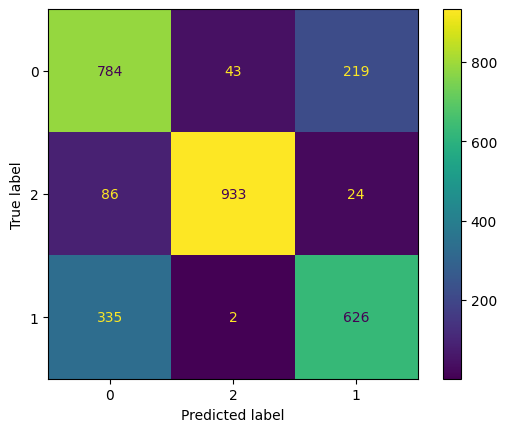

In [51]:
# load model from file instead of training
# model = tf.keras.models.load_model("model.keras")

# Quick variant used for model training and tuning
loss, acc = model.evaluate(X_test, y_test, verbose=None)
print("Model accuracy: {:5.2f}%".format(100 * acc))

# Build confusion matrix
pred = model.predict(X_test, verbose=None)
y_pred = np.argmax(pred, axis=1)
cm = confusion_matrix(y_test, y_pred, labels=labels["label"].unique())
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels["label"].unique())
cm_disp.plot()
plt.show()


### Deployment Notes

The model trained and presented above needs additional work to be able to be sensibly deployed to production. Three major aspects have to be considered:

1. The model currently requires specially formatted input, that is different from the `.csv` batch data, that was presented for training. Luckily trainsforming a single batch into 256 reading sequences is fairly simple and the code from above can be reused. Assuming the data of a batch was parsed into the variable `batch` the following snipped can be included as part of the model pipeline.
```python
batch = batch.sort_values('zeit')
for i in range(0, len(batch) - SEQUENCE_LENGTH, SEQUENCE_LENGTH):
  sequence = batch.iloc[i:i + SEQUENCE_LENGTH]
  sequences.append(sequence[['zeit', 'sensorid', 'messwert']].values)
```

2. The predictions made by the model (with ~76% accuracy) are for 256 reading sequences instead for a full batch (which I assume to be the goal in deployment). To predict a full batch a simple method like simple majority voting based on the predictions for sequences can be applied to determine the prediction for the batch.

3. While the best model has an accuracy of ~76%, it is worthy to point out, that several other models with smaller sequences and fewer LSTM units have achieved almost similar results. In a real world deployment model size and complexity should be considered. I will hand in said best configuration, but at the cost of 3-4% accuracy a significantly smaller model could be used alternatively.